<center><h1>Brain Tumor Detection</h1><center>

# Importing Essential Libraries and Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

# Loading the Data

We load the data by making use of the tool image_dataset_from directory. It helps us fetch the data from the relevant directory, automatically does labeling, shuffles the data, batches the data (in this case as 32) and resizes images into 256 by 256.

In [2]:
data = keras.utils.image_dataset_from_directory("Brain Dataset/MRI brain_tumor_DS")

Found 253 files belonging to 3 classes.


<h3>Plotting a few Example Images</h3>

If a brain has tumor it is labeled as 1, if no it is labeled as 0.

In [3]:
batch = data.as_numpy_iterator().next()

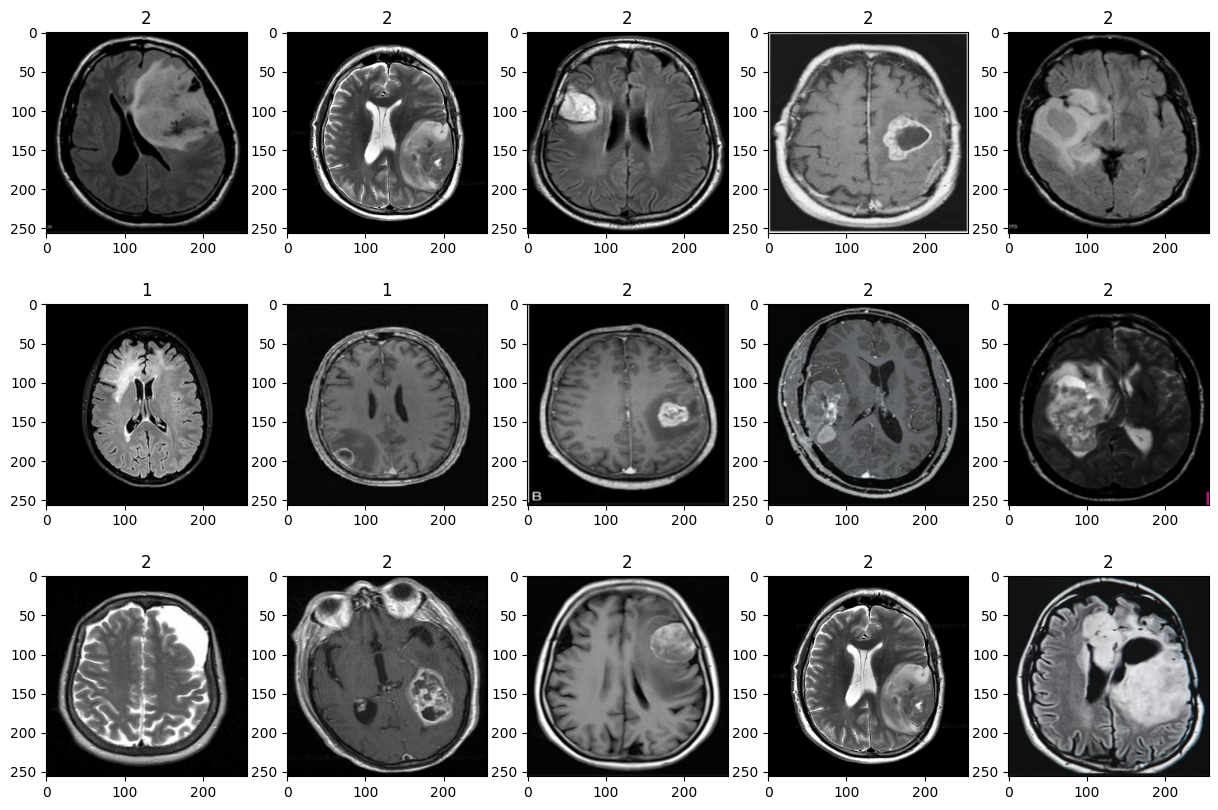

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

We load the data by making use of the tool image_dataset_from directory. It helps us fetch the data from the relevant directory, automatically does labeling, shuffles the data, batches the data (in this case as 32) and resizes images into 256 by 256.

In [5]:
data = keras.utils.image_dataset_from_directory("Brain Dataset/MRI brain_tumor_DS")

Found 253 files belonging to 3 classes.


<h3>Plotting a few Example Images</h3>

If a brain has tumor it is labeled as 1, if no it is labeled as 0.

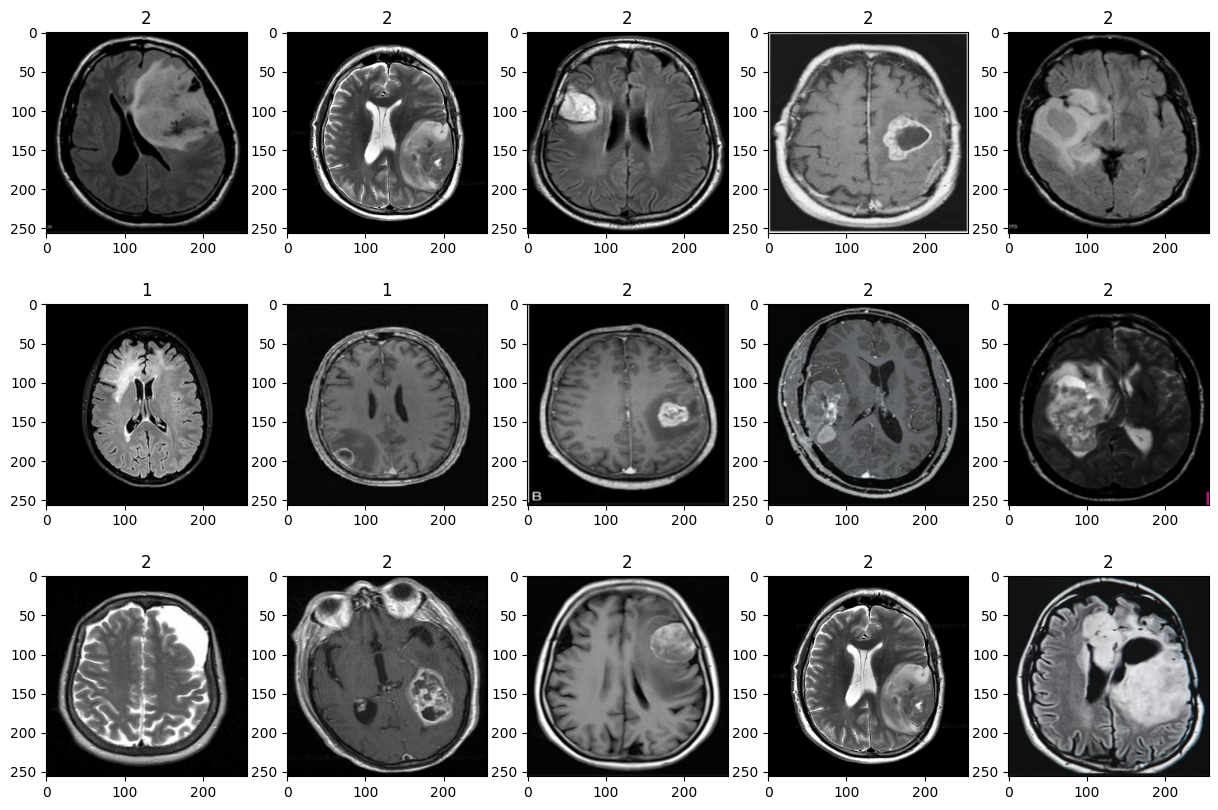

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data Scaling

Since our data consists of images and images consist of pixels, we divide all the pixel values by 255—each pixel can have a value in [0, 255]— so that all the pixel values are on the same scale i.e. [0, 1].

In [7]:
data = data.map(lambda x,y: (x/255, y))

In [8]:
batch = data.as_numpy_iterator().next()

In [9]:
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


# Train-Validation-Test Split

In [10]:
print("There are", len(data), "batches in our data")

There are 8 batches in our data


Now, we have to divide the whole data into 3 separate sets: Train set for training the model, Validation set for adjusting the hyperparameters of our model and Test set for evaluating our model on the set that our model has not seen before. As it can be seen, we have 8 batches in our data. I preferred allocating 4 batches for Train set, 2 batches for Validation set and 2 batches for Test set.

In [11]:
train_size = int(len(data)*0.6)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.2)+1

In [12]:
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

print("Sum of Train, Validation and Test sizes is equal to:", train_size + val_size + test_size)

Train Size: 4
Validation Size: 2
Test Size: 2
Sum of Train, Validation and Test sizes is equal to: 8


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Data Augmentation

Because our Train set has relatively small number of images, we can apply data augmentation which is reproducing the images by applying some changes such as random rotating, random flipping, random zoom and random contrast. This may possibly increase the accuracy score of the model. Since we will be applying the data augmentation in the beginning of the neural network architecture, we should pass the input shape.

Note: Data augmentation will be inactive when testing the data. Input images will be augmented during calls to model.fit (not model.evaluate or model.predict).

In [14]:
batch = data.as_numpy_iterator().next()

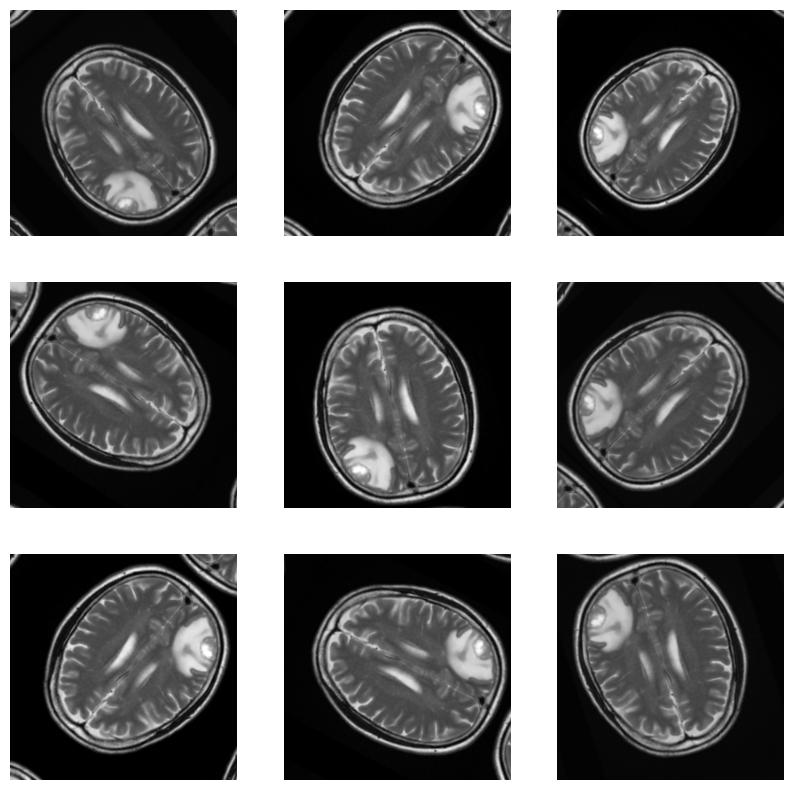

In [15]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

image = batch[0]


plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Building a Deep Learning Model

In [16]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [17]:
model.compile(loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      25632     
                                                      

In [19]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 3/15
4/4 [==============================] - 42s 11s/step - loss: -1571503.7500 - accuracy: 0.4297 - val_loss: -7996121.0000 - val_accuracy: 0.3750
Epoch 4/15
4/4 [==============================] - 44s 12s/step - loss: -30028872.0000 - accuracy: 0.3359 - val_loss: -82846000.0000 - val_accuracy: 0.3750
Epoch 5/15
4/4 [==============================] - 39s 10s/step - loss: -204229808.0000 - accuracy: 0.3438 - val_loss: -483378560.0000 - val_accuracy: 0.3594
Epoch 6/15
4/4 [==============================] - 38s 10s/step - loss: -765324288.0000 - accuracy: 0.4375 - val_loss: -1567930240.0000 - val_accuracy: 0.3906
Epoch 7/15
4/4 [==============================] - 38s 10s/step - loss: -2483495680.0000 - accuracy: 0.3906 - val_loss: -4401326080.0000 - val_accuracy: 0.4219
Epoch 8/15
4/4 [==============================] - 44s 10s/step - loss: -6362784256.0000 - accuracy: 0.4141 - val_loss: -10045296640.0000 - val_accuracy: 0.4219
Epoch 9/15
4/4 [==============================] - 40s 10s/

# Performance Plotting 

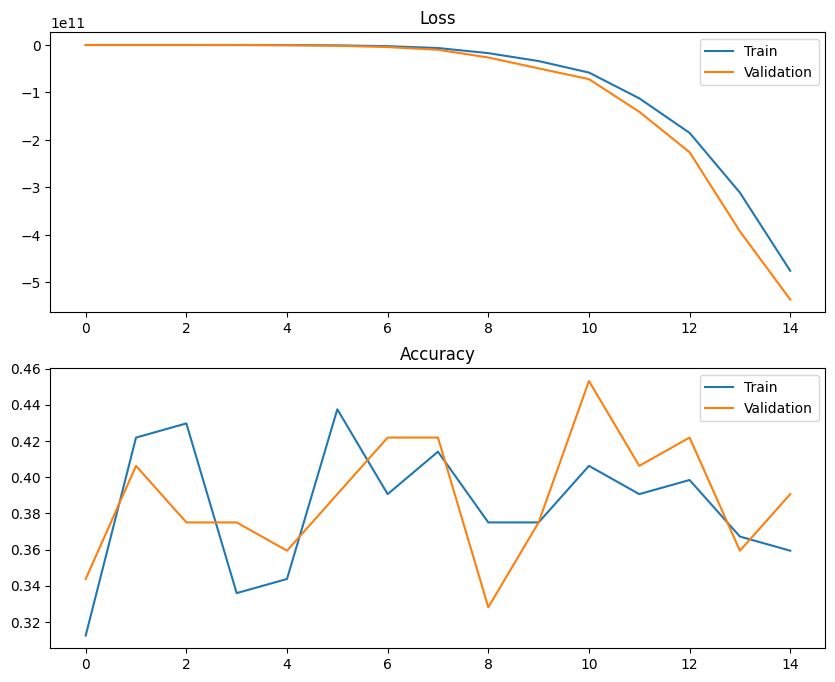

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

# Results

In [21]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

1/1 [==============================] - 2s 2s/step
Accuracy: 0.40983605 
Recall: 1.0 
Precision: 1.0


# Manual Testing

We have already evaluated our model using various metrics and visualizations but it is always a good practice to test the model by hand to make sure everything is working well. In the code below, I randomly chose an image and plotted it with its true label on title so let's see if our model is going to classify this example correctly.

In [42]:
batch = test.as_numpy_iterator().next()

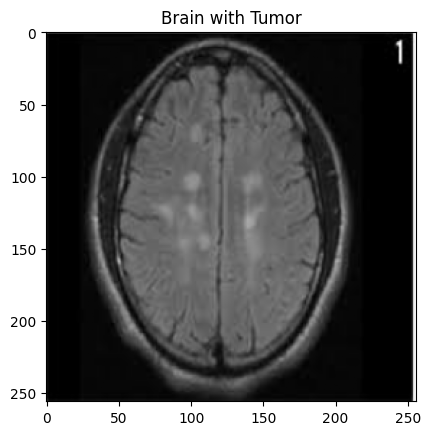

In [43]:
img, label = batch[0][15], batch[1][15]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [44]:
y_hat = model.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 78ms/step


We are able to see the probability of this brain's having tumor below. I opted to determine the classification threshold as 0.5. Meaning that, if it is below 0.5 this will be classified as Brain Having No Tumor otherwise it is going to be classified as Brain Having Tumor.

In [45]:
y_hat

array([[1.]], dtype=float32)

In [46]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

Tumor detected
